##1. Installation of Libraries needed
* This section of the code installs additional libraries needed in the execution environment.

In [ ]:
# Sentence Transformers: Computing Sentence Embeddings and Similarity
!pip install sentence_transformers
# Sentence Piece: Text tokenization for the T5 tokenizer
!pip install sentencepiece
# Matplotlib: For Data Visualization
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 6.6 MB/s eta 0:00:00


##2. Import Libraries Needed
* The required libraries are imported. The purpose of each imported library is marked in the comments.

In [ ]:
# Import required libraries - Usage of library mentioned in comments
import os       # Saving and loading checkpoints
import re       # RegEx: Text preprocessing of Dialogue pairs and User Input
import gc       # Clearing GPU memory
import math     # Perplexity calculations
import time     # Tracking training time and progress
import torch    # Model training evaluation and deployment
import random   # Sample selection for prints
import matplotlib.pyplot as plt     # Data visualization
from collections import Counter     # Counting word frequencies
from tqdm import tqdm               # Progress bar
from torch.optim import AdamW       # Optimizer for training the model
# Custom dataset class and loading data in batches
from torch.utils.data import Dataset, DataLoader
# Core model architecture and Tokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
# Learning rate scheduling
from transformers import get_linear_schedule_with_warmup
# Dialogue pair Cosine similarity Calculation
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

##3. Compute Device Selection
* If the computing environment has available GPU, processing will be performed on the GPU.
* In case if there are no GPUs available, CPU will be used for processing.

In [ ]:
# Check if a GPU is available and use if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(device))

# Fallback to CPU if GPU not available
else:
    device = torch.device("cpu")
    print("Using CPU")

# Print the Device being used for computation
print(f"Using device: {device}")

Using GPU: NVIDIA A100-PCIE-40GB
Using device: cuda


##4. Data Storage Access
* This code was developed predominantly on Google Colab environment. The dataset, intermediate training checkpoints and final dataset are stored in the Google drive.
* This section of the code provides the code Google Dive access with relevant user credentials.


In [ ]:
# Mount google drive for accessing Complaints dataset
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Data

Mounted at /content/drive
/content/drive/MyDrive/Data


##5. Dataset Loading
* The Cornell Movie dialogue dataset is loaded and each line of the file is parsed to extract the conversation from the 5th field.
* This dataset is found to have 304,446 conversations. Upon inspection of the conversation it is evident that most of the conversations are short, which requires preprocessing before usage for training.


In [ ]:
# Load Cornell Movie Dialogues Dataset

# Function to load and parse the Cornell Movie Dialogues dataset
def load_cornell_data(file_path):
    conversations = []
    # Open File with ISO-8859-1 encoding to handle special characters
    with open(file_path, 'r', encoding='iso-8859-1') as f:
        for line in f:
            # Each line is a dialogue turn
            conversation = line.strip().split(" +++$+++ ")
            # Confirming the line for conversation validity
            if len(conversation) == 5:
                # Extracting conversation from the 5th field
                conversations.append(conversation[4])
    return conversations

# Load the Cornell dataset
cornell_file = './Cornell/movie_lines.txt'
dialogues = load_cornell_data(cornell_file)

# Print total number of dialogue lines in the dataset
print(f"Total number of dialogues: {len(dialogues)}")

# Display first 25 dialogues for inspection
print("\nSample dialogues:")
for i in range(25):
    print(f"{i+1}. {dialogues[i]}")

Total number of dialogues: 304446

Sample dialogues:
1. They do not!
2. They do to!
3. I hope so.
4. She okay?
5. Let's go.
6. Wow
7. Okay -- you're gonna need to learn how to lie.
8. No
9. I'm kidding.  You know how sometimes you just become this "persona"?  And you don't know how to quit?
10. Like my fear of wearing pastels?
11. The "real you".
12. What good stuff?
13. I figured you'd get to the good stuff eventually.
14. Thank God!  If I had to hear one more story about your coiffure...
15. Me.  This endless ...blonde babble. I'm like, boring myself.
16. What crap?
17. do you listen to this crap?
18. No...
19. Then Guillermo says, "If you go any lighter, you're gonna look like an extra on 90210."
20. You always been this selfish?
21. But
22. Then that's all you had to say.
23. Well, no...
24. You never wanted to go out with 'me, did you?
25. I was?


##6. Dialogue Preprocessing
* Inspection of the dialogue reveaaled presence of many contractions (such as we've), consecutive hyphes, multiple dots, double quotes and additional spaces which may reduce the learning effectiveness.
* In this section of the code, the contractions are expanded, hyphens and dots are substituted with space, standalone puntuations are removed, and finally the consecutive spaces are removed.
* The cleaned dialogues are inspected and found to be suitable for Question-Answer pairing.

In [ ]:
# Precompiles regex patterns for text clean up
# Replacing Contraction with expanded form
contraction_patterns = [(re.compile(r'\b{}\b'.format(re.escape(k)), re.IGNORECASE), v) \
    for k, v in {"I'm": "I am", "you're": "you are", "he's": "he is",
    "she's": "she is", "it's": "it is", "we're": "we are",
    "they're": "they are", "I've": "I have", "you've": "you have",
    "we've": "we have", "they've": "they have", "I'd": "I would",
    "you'd": "you would", "he'd": "he would", "she'd": "she would",
    "we'd": "we would", "they'd": "they would", "I'll": "I will",
    "you'll": "you will", "he'll": "he will", "she'll": "she will",
    "we'll": "we will", "they'll": "they will", "isn't": "is not",
    "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
    "won't": "will not", "wouldn't": "would not", "don't": "do not",
    "doesn't": "does not", "didn't": "did not", "can't": "cannot",
    "couldn't": "could not", "shouldn't": "should not", "let's": "let us",
    "Let's": "Let us", "that's": "that is", "That's": "That is",
    "She's": "She is", "He's": "He is", "It's": "It is",
    "You're": "You are", "You've": "You have", "You'll": "You will",
    "would've": "would have", "should've": "should have",
    "could've": "could have", "I'd": "I would", "I'll": "I will",
    "I'm": "I am", "I've": "I have", "Can't": "Cannot", "Don't": "Do not",
    "Didn't": "Did not", "What's": "What is", "What're": "What are",
    "where's": "where is", "Where're": "Where are", "Who're": "Who are",
    "there's": "there is", "There's": "There is", "Aren't": "Are not",
    "aren't": "are not", "Couldn't": "Could not", "mightn't": "might not",
    "mustn't": "must not", "Where've": "Where have", "He'll": "He will",
    "You'd": "You would", "We're": "We are", "How'd": "How did",
    "What'd": "What did", "What've": "What have", "They're": "They are",
    "Haven't": "Have not", "who'll": "who will", "Who's": "Who is",
    "this'll": "this will", "Why'd": "Why did", "It'd": "It would",
    "There'll": "There will", "how'd": "how did", "C'mere": "Come here",
    "We'd": "We would", "here's": "here is", "nobody's": "nobody is",
    "How's": "How is", "Now's": "Now is", "man's": "man is"}.items()]
# Removal of punctuation characters ["!;:]
punctuation_pattern = re.compile(r'["!;:]')
# Replace consecutive spaces with single space
multiple_spaces_pattern = re.compile(r'\s+')

# Text Clean up function using Reg Ex Precompiled Patterns
def clean_text(text):
    # Replace contractions using precompiled patterns
    for pattern, replacement in contraction_patterns:
        text = pattern.sub(replacement, text)

    # Replace punctuation and multiple spaces as briefed below
    text = re.sub(r'--+', ' ', text)  # Replace -- or --- with single space
    text = re.sub(r'\.{2,}', ' ', text)  # Replace consecutive . with a space
    text = punctuation_pattern.sub('', text)  # Remove standalone punctuation
    text = multiple_spaces_pattern.sub(' ', text).strip()  # Replace multi spaces

    return text

# Apply text cleaning to each dialogue
cleaned_dialogues = [clean_text(dialogue) for dialogue in dialogues]

# Display first 25 dialogues for inspection
print("\nSample Cleaned dialogues:")
for i in range(25):
    print(f"{i+1}. {cleaned_dialogues[i]}")


Sample Cleaned dialogues:
1. They do not
2. They do to
3. I hope so.
4. She okay?
5. let us go.
6. Wow
7. Okay you are gonna need to learn how to lie.
8. No
9. I am kidding. You know how sometimes you just become this persona? And you do not know how to quit?
10. Like my fear of wearing pastels?
11. The real you.
12. What good stuff?
13. I figured you would get to the good stuff eventually.
14. Thank God If I had to hear one more story about your coiffure
15. Me. This endless blonde babble. I am like, boring myself.
16. What crap?
17. do you listen to this crap?
18. No
19. Then Guillermo says, If you go any lighter, you are gonna look like an extra on 90210.
20. You always been this selfish?
21. But
22. Then that is all you had to say.
23. Well, no
24. You never wanted to go out with 'me, did you?
25. I was?


##7. Dialogue Length Distribution
* Dialogue sample inspection highlighted the presence of dialogues with very few words. This section analyzes the distribution of word count in the dialogues.
* The word count distribution analysis shows that average word count per dialogue is 11.55 words, with the most of the dialogues having less than 64 words.
* Based on the distribution the maximum token length in tokenization and model training is set to 64, which optimizes the memory utilization and shortens the training duration.

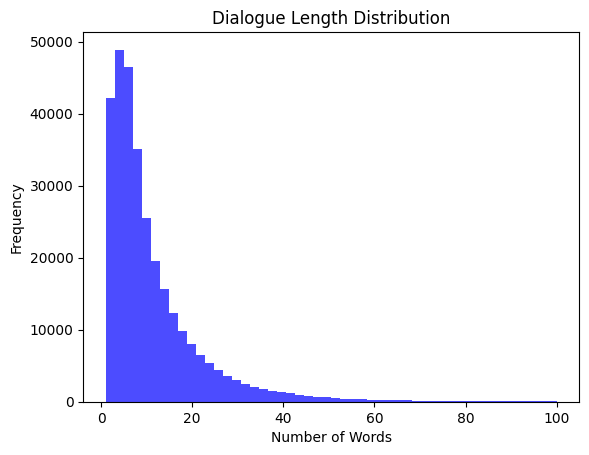

Average dialogue length: 11.08 words


In [ ]:
# Dialogue length distribution analysis

# Calculate each dialogue word count by splitting dialogue with blankspace
dialogue_lengths = [len(dialogue.split()) for dialogue in cleaned_dialogues]

# Focus on dialogue lengths less than 100 for better visualization
filtered_dialogue_lengths = [length \
                             for length in dialogue_lengths if length <= 100]

# Dialogue Word Count Histogram
plt.hist(filtered_dialogue_lengths, bins=50, color='blue', alpha=0.7)
plt.title("Dialogue Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Calculate and Print Average dialogue length
avg_length = sum(dialogue_lengths) / len(dialogue_lengths)
print(f"Average dialogue length: {avg_length:.2f} words")

##8. Most Frequent Words
* The dialogue set is inspected for most repeating words, so that any irrelevant words can be filtered out. This dialogue set has more of stop words, which is normal in any coversation. The stopwords are not removed due to their critical role in natural conversation of the chatbot.


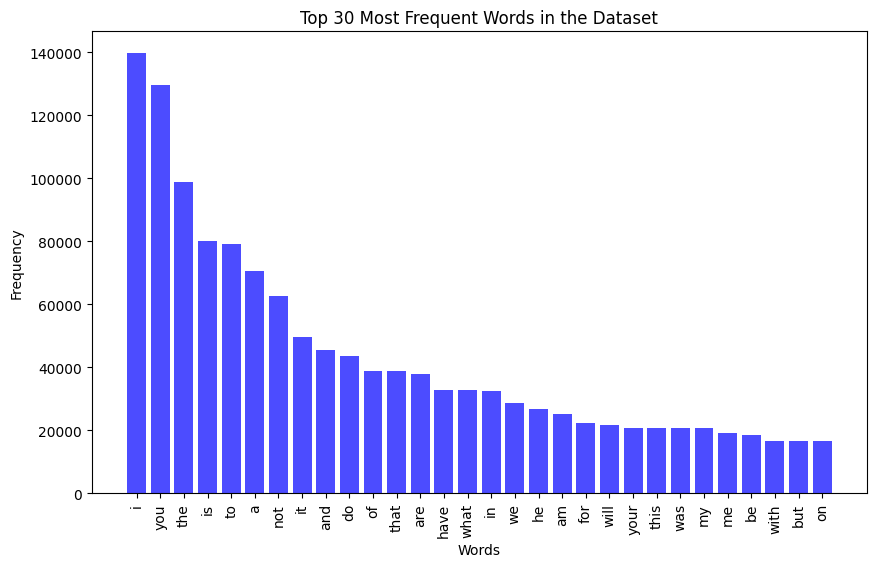

In [ ]:
# Identify most frequently used words in the dataset

# Join dialogues into single string, covert to lower case & split on blanks
all_words = ' '.join(cleaned_dialogues).lower().split()

# Count word frequencies, Extract top 30
common_words = Counter(all_words).most_common(30)

# Separate Words and Frequencies into independent list
words, frequencies = zip(*common_words)

# Histogram of Word occurence
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='blue', alpha=0.7)
plt.title("Top 30 Most Frequent Words in the Dataset")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

##9. Question-Answer Pair Formation
* This section of the code pair consecutive dialogues as Input (Question) and Response (Answer) pairs, so that QA pair can be used for training the chatbot model.
* Each of the conversation is considered as the Input, with the following dialogue as the response. All the dialogue pairs need not be relevant. Hence the irrelevant pairs would be removed in subsequent stages.
* Few of the dialogue pairs are printed for inspection.

In [ ]:
# Prepare input-response (QA) pairs by combining consecutive dialogue lines

# Each dialogue line is considered as the input, with next line as the response.
qa_pairs = [(cleaned_dialogues[i], cleaned_dialogues[i+1]) \
            for i in range(len(cleaned_dialogues) - 1)]

# Print a few random QA pairs
def print_random_qa_pairs(qa_pairs, num_samples=5):
    print(f"Showing {num_samples} random input-response pairs:")
    for i in range(num_samples):
        # Select a random pair
        input_text, response_text = random.choice(qa_pairs)
        print(f"\nPair {i+1}:")
        print(f"  Input: {input_text}")
        print(f"  Response: {response_text}")

# Call the function to print random QA pairs
print_random_qa_pairs(qa_pairs, num_samples=5)

Showing 5 random input-response pairs:

Pair 1:
  Input: Oh my God.
  Response: My husband will be back quite late.

Pair 2:
  Input: Why not? Sam, is she hiding here? Are you two planning to go away with the money?
  Response: No.

Pair 3:
  Input: Be ruled by me, forget to think of her.
  Response: She hath, and in that sparing makes huge waste.

Pair 4:
  Input: Any universe that exists or ever existed. You may be the pro, Joe. But I know who you are. And you are all fucked up.
  Response: This universe?

Pair 5:
  Input: How come he is suddenly so forth- coming? I would like to kick him right in the ass. If he would discussed it with me, I mighta gotten somewhere
  Response: Yeah, in and outta Frisco on the big boats Every lead we had went right out to sea Night, night, Freddy T John


##10. Preprocessing Dialogue Pairs with Keyword and Relative Word Count
* The chatbot response quality depends on the training input response pairs. Hence, it is essential to ensure that each responses is relevant to the input dialogue.
* This section of the code checks the response for commonality of the keywords to the input dialogue. If the the commonality is greater than the threshold the dialogue pair is qualified towards training.
* In addition, the dialogue is discarded if the the response length is below 2 words or greater than 64 words, or if the response is too shorter than the input dialogue to ensure meaningful conversations.

In [ ]:
# Preprocessing dialogues and Filtering out Irrelevant Dialogue Pairs

# Function to drop irrelevant QA pair based on a criterion
# Keyword threshold: minimum number of common words between input & response
# Length difference: Normalized length differene to be less than thershold
# Min Response Length: Minimum Number of words permitted in response
# Max Response Length: Maximum Number of words permitted in response
def clean_qa_pairs(qa_pairs, keyword_threshold=1, length_diff_threshold=1.0,\
                   min_resp_length=3, max_resp_length=64):
    cleaned_pairs = []

    for input_text, response_text in qa_pairs:

        # Tokenize input and response texts, convert to lower case
        input_words = set(re.findall(r'\b\w+\b', input_text.lower()))
        response_words = set(re.findall(r'\b\w+\b', response_text.lower()))

        # Calculate keyword overlap
        overlap = len(input_words.intersection(response_words))

        # Calculate length difference ratio (prevent division by zero)
        len_input = len(input_words)
        len_response = len(response_words)
        max_len = max(len_input, len_response)

        # Remove conversation if both input and response are blanks
        if max_len == 0:
            continue

        # If response lenght is outside the min-max range drop QA pair
        if len_response < min_resp_length or len_response > max_resp_length:
            continue

        # Calculate absolute QA pair length difference normalized by maxlen(QA)
        length_diff = abs(len_input - len_response) / max_len

        # If the input is smaller than output by large range skip QA pair
        if len_response < len_input and length_diff >= length_diff_threshold:
            continue

        if overlap >= keyword_threshold:
            cleaned_pairs.append((input_text, response_text))

    return cleaned_pairs

# Print number of QA pairs before cleaning
print(f"Number of QA pairs before cleaning: {len(qa_pairs)}")

# Clean the QA pairs using thresholds for keyword overlap, length difference, and semantic similarity
cleaned_qa_pairs = clean_qa_pairs(qa_pairs, keyword_threshold=1, \
        length_diff_threshold=0.85, min_resp_length=2, max_resp_length=64)

# Print number of QA pairs after cleaning
print(f"Number of QA pairs after cleaning: {len(cleaned_qa_pairs)}")

# Print a few cleaned QA pairs
print("\nSample cleaned QA pairs with similarity scores:")
for i in range(min(5, len(cleaned_qa_pairs))):
    print(f"Input: {cleaned_qa_pairs[i][0]}")
    print(f"Response: {cleaned_qa_pairs[i][1]}\n")


Number of QA pairs before cleaning: 304445
Number of QA pairs after cleaning: 145657

Sample cleaned QA pairs with similarity scores:
Input: They do not
Response: They do to

Input: What good stuff?
Response: I figured you would get to the good stuff eventually.

Input: I figured you would get to the good stuff eventually.
Response: Thank God If I had to hear one more story about your coiffure

Input: Thank God If I had to hear one more story about your coiffure
Response: Me. This endless blonde babble. I am like, boring myself.

Input: What crap?
Response: do you listen to this crap?



##11. Dialogue Pair Cosine Similarity Analysis
* This section of the code calculates the semantic similarity between the input and dialogue pair using sentence embedding and plots the histogram of reponse relevance.
* The cosine similarity histogram reveals that the overall dialog pair has very less relevance, with most of the dialogue pairs having 0.2 cosine similarity.
* This leads to a trade off between training dataset quality and quantity. If the relevance threshold is set higher, there would be very less qualified dialog pair available for training.  

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Processing similarity scores for QA pairs...
Processing 145657 QA pairs in batches of 64...


100%|██████████| 2276/2276 [02:27<00:00, 15.44it/s]



Sample cleaned QA pairs with cosine similarity scores:
Input: They do not
Response: They do to
Cosine Similarity: 0.7688

Input: What good stuff?
Response: I figured you would get to the good stuff eventually.
Cosine Similarity: 0.4008

Input: I figured you would get to the good stuff eventually.
Response: Thank God If I had to hear one more story about your coiffure
Cosine Similarity: 0.1216

Input: Thank God If I had to hear one more story about your coiffure
Response: Me. This endless blonde babble. I am like, boring myself.
Cosine Similarity: 0.2184

Input: What crap?
Response: do you listen to this crap?
Cosine Similarity: 0.3696



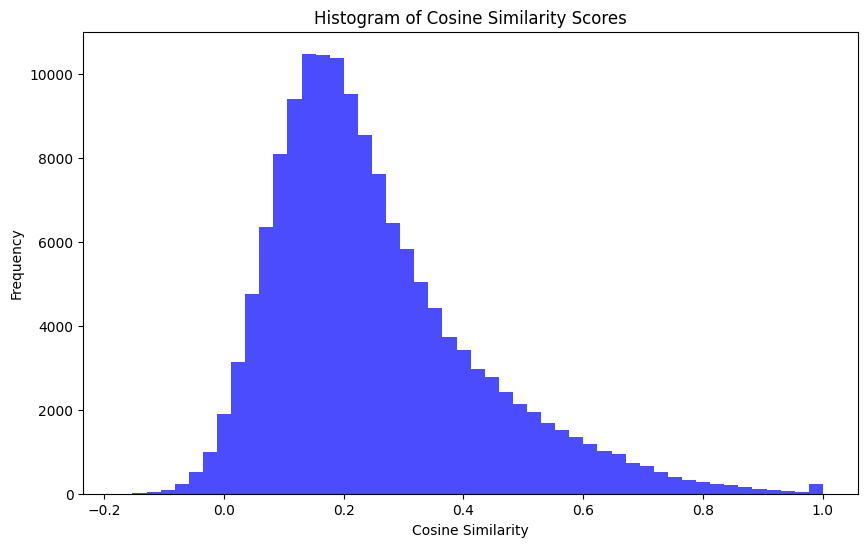

In [ ]:
# Check if GPU is available and use it
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load a pre-trained SentenceTransformer model and move it to GPU if available
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Function to calculate cosine similarity between two sentence embeddings
def get_cosine_similarity(input_embedding, response_embedding):
    # Calculate cosine similarity (dot product divided by magnitudes)
    similarity = cosine_similarity([input_embedding], [response_embedding])
    return similarity[0][0]  # Return the similarity score

# Optimized function to compute cosine similarity on QA pairs with batch processing
def compute_similarity_in_batches(qa_pairs, batch_size=64):
    # Split the inputs and responses
    inputs = [pair[0] for pair in qa_pairs]
    responses = [pair[1] for pair in qa_pairs]

    # Create DataLoader for batching
    data_loader = DataLoader(list(zip(inputs, responses)), \
                batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
    similarity_scores = []

    print(f"Processing {len(qa_pairs)} QA pairs in batches of {batch_size}...")

    # Iterate through batches and calculate similarities with progress tracking
    for batch in tqdm(data_loader):
        # Unpack the batch into inputs and responses
        batch_inputs, batch_responses = zip(*batch)

        # Encode batch of input sentences, move embeddings to GPU if available
        input_embeddings = model.encode(list(batch_inputs), \
                                  convert_to_tensor=True, device=device)

        # Encode batch of response sentences, move embeddings to GPU if available
        response_embeddings = model.encode(list(batch_responses), \
                                    convert_to_tensor=True, device=device)

        # Calculate cosine similarities for each pair in the batch
        for input_emb, response_emb, input_text, response_text in \
        zip(input_embeddings, response_embeddings, batch_inputs, batch_responses):
            # Move embeddings back to CPU for sklearn cosine similarity
            input_emb = input_emb.cpu().numpy()
            response_emb = response_emb.cpu().numpy()
            similarity = get_cosine_similarity(input_emb, response_emb)
            similarity_scores.append((input_text, response_text, similarity))

    return similarity_scores

# Assuming you already have 'cleaned_qa_pairs' from previous processing
print("Processing similarity scores for QA pairs...")
similarity_scores = compute_similarity_in_batches(cleaned_qa_pairs, batch_size=64)

# Display a few examples with similarity scores
print("\nSample cleaned QA pairs with cosine similarity scores:")
for i in range(min(5, len(similarity_scores))):
    print(f"Input: {similarity_scores[i][0]}")
    print(f"Response: {similarity_scores[i][1]}")
    print(f"Cosine Similarity: {similarity_scores[i][2]:.4f}\n")

# Extract just the similarity scores
scores = [score for _, _, score in similarity_scores]

# Plot the histogram of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

##12. Dialog Pair Pruning based on Cosine Similarity
* Considering the quantity vs quality trade off, the Cosine Similarity threshold for the dialog pair is set to 0.05, which selects 135,992 relevant dialog pairs for training.
* Few of the selected dialogue pairs are printed for inspection along with the associated cosine similarity matrix for review.

In [ ]:
# Define the similarity threshold
similarity_threshold = 0.05  # 5% based on the above analysis

# Filter QA pairs that exceed the similarity threshold
filtered_qa_pairs = [(input_text, response_text, score)
                     for input_text, response_text, score in similarity_scores
                     if score >= similarity_threshold]

# Create a new list without similarity scores
qa_pairs_train = [(input_text, response_text) \
                  for input_text, response_text, _ in filtered_qa_pairs]

# Print the number of pairs that meet the threshold
print(f"Number of QA pairs with similarity >= \
            {similarity_threshold}: {len(filtered_qa_pairs)}")

# Optionally, display a few examples that meet the threshold
print("\nSample QA pairs with high cosine similarity scores (>= 0.7):")
for i in range(min(5, len(filtered_qa_pairs))):
    print(f"Input: {filtered_qa_pairs[i][0]}")
    print(f"Response: {filtered_qa_pairs[i][1]}")
    print(f"Cosine Similarity: {filtered_qa_pairs[i][2]:.4f}\n")

Number of QA pairs with similarity >= 0.05: 135992

Sample QA pairs with high cosine similarity scores (>= 0.7):
Input: They do not
Response: They do to
Cosine Similarity: 0.7688

Input: What good stuff?
Response: I figured you would get to the good stuff eventually.
Cosine Similarity: 0.4008

Input: I figured you would get to the good stuff eventually.
Response: Thank God If I had to hear one more story about your coiffure
Cosine Similarity: 0.1216

Input: Thank God If I had to hear one more story about your coiffure
Response: Me. This endless blonde babble. I am like, boring myself.
Cosine Similarity: 0.2184

Input: What crap?
Response: do you listen to this crap?
Cosine Similarity: 0.3696



##13. Perplexity Evaluation Metric
* This section of code provides evaluation code for the trained model which will be called at the end of the training to evaluate the model.
* The perplexity matrix provides the exponential of the loss function. Given the short amount of training data the perplexity score would be very high.
* However, training with more additionaly synthetic data with paraphrasing can improve the perplexity score (reduce perplexity, as lower the perplexity is better).

In [ ]:
# Perplexity Metric calculation function to evaluate the trained model

# Function to calculate perplexity from the average loss
def calculate_perplexity(loss):
    try:
        return math.exp(loss)
    except OverflowError:
        # Handle very large loss leading to overflow
        return float('inf')

# Function to evaluate model and return loss and perplexity
def evaluate_model(dataloader, model, device):
    # Set the model to evaluation mode
    model.eval()
    total_loss = 0.0
    total_steps = 0

    with torch.no_grad():   # Disable gradient calculation
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, \
                            attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Accumulate total loss and steps
            total_loss += loss.item()
            total_steps += 1

    # Calculate average loss over all batches
    avg_loss = total_loss / total_steps

    # Calculate perplexity
    perplexity = calculate_perplexity(avg_loss)

    print(f"Validation Loss: {avg_loss:.2f}, Perplexity: {perplexity:.2f}")
    return avg_loss, perplexity

##14. Loading Pretrained Model and Tokenizer
* This chatbot uses FLAN-T5 pretrained model from Hugging face, fine tuned with Cornell Movie Dialogue corpus. This section of the code loads the tokenizer and model for the chatbot model.
* The T5 tokenizer converts text into vector representation called as token IDs for the model to process. The tokenizer can also convert back the token IDs into human readable text.
* FLAN-T5 is a variant of the T5 fine tuned on instruction based tasks such as responding to text input, which makes it suitable for multi-turn conversation.

In [ ]:
# Load the Pre-trained FLAN-T5 Model and Tokenizer

# Load the pre-trained tokenizer for FLAN-T5 from Hugging Face Model Hub
# Used to convert input text into tokens, and vice versa
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

# Load the pre-trained FLAN-T5 model for Conditional Generation
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Move the model to GPU or CPU based on availability
model = model.to(device)

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


##15. Custom Dataset with Tokenization and Data Loader
* This section of the code creates a custom PyTorch dataset for tokenizing the QA dialogue pairs and easy loading of the data into the model for training or evaluation, along with a Dataloader function that loads the data in batches.
* The dataset tokenizes the input and target text using pre-trained tokenizer, trunctes to the specified max length (64 in our model baed on the conversation length) with padding. The input token ids, input attention mask and output (label) token ids are returned.
* The Data loader loads the shuffled data in batches into the model with suitable batch size and workers based on the computing device capability.

In [ ]:
# Create a Custom Dataset and Dataloader for the dialogue pairs

# Custom PyTorch Dataset class to prepare QA pairs for training & evaluation
class CornellQADataset(Dataset):
    # Initialize the dataset with QA pairs, tokenizer and max_length
    def __init__(self, qa_pairs, tokenizer, max_length=512):
        self.pairs = qa_pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    # Define length of dataset
    def __len__(self):
        return len(self.pairs)

    # Retrieve specific dialogue pair (input, target) by index
    def __getitem__(self, idx):

        # Extract input and target texts from the QA pair
        input_text, target_text = self.pairs[idx]

        # Tokenize input texts truncated to max_length, with padding
        input_enc = self.tokenizer.encode_plus(
            input_text, max_length=self.max_length, padding="max_length", \
                  truncation=True, return_tensors="pt"
        )

        # Tokenize target texts truncated to max_length, with padding
        target_enc = self.tokenizer.encode_plus(
            target_text, max_length=self.max_length, padding="max_length", \
                  truncation=True, return_tensors="pt"
        )

        # Return Input token ID, Input Attention mask, Target token ID
        return {
            'input_ids': input_enc['input_ids'].flatten(),
            'attention_mask': input_enc['attention_mask'].flatten(),
            'labels': target_enc['input_ids'].flatten()
        }

# Create a Dataset and Dataloader for Training
dataset = CornellQADataset(qa_pairs_train, tokenizer, max_length=64)

# DataLoader with larger batch size for the A100 GPU
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

##16. Training Configuration and Preparation
* This section of the code sets up the training environment to either start from scratch or to resume from where the training stopped during previous run.
* The batch size, learning rate and gradient accumulation steps are tuned to leverage A100 GPU on which the model is trained.
* The learning rate schedule includes a warm up phase during which the learning rate increases and then slowly decays while training progresses, which ensures training stability. The code also adapts the learning rate if the batch size is changed while training.
* If the training is resumed, the optimizer and scheduler states are restored to ensure smooth continuation in the training progress.

In [ ]:
# Path to the checkpoint directory
checkpoint_dir = './checkpoint'

# Check if there is a saved checkpoint with checkpoint directory existence
# If check point exists, resume training from the last saved state
resume_training = os.path.exists(checkpoint_dir)

# Load model and tokenizer
if resume_training:
    print(f"Resuming from checkpoint: {checkpoint_dir}")
    # If resuming, Load model and tokenizer from the checkpoint directory
    model = T5ForConditionalGeneration.from_pretrained(checkpoint_dir)
    tokenizer = T5Tokenizer.from_pretrained(checkpoint_dir)
else:
    print("Starting from scratch.")
    # If starting, Load model and tokenizer from afresh
    model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
    tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

# Move the model to the GPU or CPU based on the availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Adjust gradient accumulation steps based on batch size
gradient_accumulation_steps = 2  # Reduced based on larger batch size

# Adjust the learning rate for larger batch size
base_learning_rate = 5e-5  # Default learning rate for base batch size
new_batch_size = 128  # New batch size if modified
old_batch_size = 32  # Old batch size, i.e, base batch size

# Scale the by the batch size update ratio
learning_rate = base_learning_rate * (new_batch_size / old_batch_size)

# Initialize the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)

# If resuming, load the optimizer and scheduler state
if resume_training:
    optimizer_checkpoint = torch.load(os.path.join(checkpoint_dir, 'optimizer.pt'))
    optimizer.load_state_dict(optimizer_checkpoint['optimizer'])
    scheduler.load_state_dict(optimizer_checkpoint['scheduler'])

# Calculate number of training steps with num(epoch) and batch size.
epochs = 3      # Number of training epochs
total_steps = len(dataloader) * epochs    # Total steps in full training
warmup_steps = int(0.1 * total_steps)     # 10% of Training step

# Initialize the linear rate scheduler with warmup
# Learning rate increases during the warmup and decreases linearly
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# Mixed precision training at GPU for memory reduction and speed up
# Automatic Mixec Precision (AMP) used when CUDA used
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

# Function to dynamically adjust gradient accumulation based on memory usage
def adjust_gradient_accumulation(device, current_step, threshold_memory=14.0):
    gc.collect()              # Garbage collection to free unused memory
    torch.cuda.empty_cache()  # Empty PyTorch's cache to free up GPU memory
    # Check the current memory usage in GB
    current_memory = torch.cuda.memory_reserved(device) / 1e9

    # If memory usage exceeds thershold, increase gradient accumulation steps
    if current_memory > threshold_memory:
        return min(16, gradient_accumulation_steps + 2)
    elif current_memory < (threshold_memory * 0.8):
        return max(4, gradient_accumulation_steps - 2)
    return gradient_accumulation_steps

# Function to print progress and estimated time remaining
def print_progress(epoch, step, total_steps, start_time):
    # Calculate elapsed time
    elapsed_time = time.time() - start_time

    # Calculate the number of steps completed and remaining
    completed_steps = epoch * len(dataloader) + step
    remaining_steps = total_steps - completed_steps

    # Estimate time remaining based on elapsed time per step
    avg_time_per_step = elapsed_time / (completed_steps + 1)
    remaining_time = avg_time_per_step * remaining_steps
    remaining_minutes = remaining_time // 60
    remaining_seconds = remaining_time % 60

    # Print the progress: Epoch, Step and Time Completed and Estimates
    print(f"Epoch: {epoch + 1}/{epochs} | Step: {step + 1}/{len(dataloader)} | "
      f"Completed Steps: {completed_steps}/{total_steps} | "
      f"Elapsed Time: {elapsed_time:.2f}s | "
      f"Estimated Time Remaining: {remaining_minutes:.0f}m {remaining_seconds:.0f}s")

Starting from scratch.


/tmp/ipykernel_377/4077945177.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None


##17. Model Training
* This section of the code handles the model training, which supports both start from scratch and resuming from previous checkpoint with Epoch, Step and Time progress and estimates to completion.
* The intermediate checkpoints are saved after every 500 steps and the final model is saved after training. The perplexity metrics is estimated by evaluating the model after training.


In [ ]:
# Initializing starting epoch and step, will be updated further if resuming
starting_epoch = 0
starting_step = 0
epochs = 3

# Update epoch and step if resuming
if resume_training:
    # Extract starting epoch and step from the checkpoint name
    checkpoint_name = os.path.basename(checkpoint_dir)
    epoch_info, step_info = checkpoint_name.split('-epoch-')[1].split('-step-')
    starting_epoch = int(epoch_info) - 1  # Extract resume epoch number
    starting_step = int(step_info)        # Extract resume step number
    print(f"Resuming from epoch {starting_epoch + 1} and step {starting_step}")

# Training loop with resumption support and progress tracking
start_time = time.time()  # Record training start time
save_steps = 500          # Save model checkpoint every 500 steps

for epoch in range(starting_epoch, epochs):
    model.train()           # Set the model for training
    epoch_loss = 0          # Initialize loss for the epoch
    optimizer.zero_grad()   # Reset gradients

    for step, batch in enumerate(dataloader):
        if epoch == starting_epoch and step < starting_step:
            continue  # Skip steps already completed in the last checkpoint

        # Move input batch to the GPU or CPU device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Mixed precision training with autocast for efficient GPU usage
        with torch.amp.autocast(device_type='cuda', \
                                enabled=(scaler is not None)):
            # Forward pass: Get model output and calculate loss
            outputs = model(input_ids=input_ids, \
                            attention_mask=attention_mask, labels=labels)
            # Scale loss for gradient accumulation
            loss = outputs.loss / gradient_accumulation_steps

        # Backward pass using mixed precision scaler if available
        scaler.scale(loss).backward() if scaler else loss.backward()

        # Perform optimization after gradient accumulation
        if (step + 1) % gradient_accumulation_steps == 0:
            # If mixed precision, Unscale gradients before optimization
            if scaler:
                scaler.unscale_(optimizer)

            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimizer step to update model weights
            if scaler:
                scaler.step(optimizer)  # Step with scaler in mixed precision
                scaler.update()         # Update scaler
            else:
                optimizer.step()        # Standard optimizer step

            optimizer.zero_grad()     # Reset gradients after optimizer step

            # Learning Rate Scheduler step after optimizer step
            scheduler.step()

        # Print training progress and estimated time remaining every 100 steps
        if (step + 1) % 100 == 0:
            total_steps = len(dataloader) * epochs  # total steps
            print_progress(epoch, step, total_steps, start_time)

        # Save model checkpoint after every 500 steps
        if (step + 1) % save_steps == 0:
            checkpoint_path = f'./checkpoint-epoch-{epoch+1}-step-{step + 1}'
            # Save the model and tokenizer at checkpoint path
            model.save_pretrained(checkpoint_path)
            tokenizer.save_pretrained(checkpoint_path)
            torch.save({
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
            }, os.path.join(checkpoint_path, 'optimizer.pt'))

    # Print the average loss for the epoch
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader)}")

# Print training completion
print("Fine-tuning complete!")

# Final evaluation after training
final_val_loss, final_val_perplexity = evaluate_model(dataloader, model, device)
print(f"Final Validation Perplexity: {final_val_perplexity:.4f}")

# Save final model and tokenizer
model.save_pretrained('./flan_t5B_cornell')
tokenizer.save_pretrained('./flan_t5B_cornell')

# Save final optimizer and scheduler states
torch.save({
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
}, './flan_t5B_cornell/optimizer.pt')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch: 1/3 | Step: 100/1063 | Completed Steps: 99/3189 | Elapsed Time: 25.92s | Estimated Time Remaining: 13m 21s
Epoch: 1/3 | Step: 200/1063 | Completed Steps: 199/3189 | Elapsed Time: 51.34s | Estimated Time Remaining: 12m 47s
Epoch: 1/3 | Step: 300/1063 | Completed Steps: 299/3189 | Elapsed Time: 76.78s | Estimated Time Remaining: 12m 20s
Epoch: 1/3 | Step: 400/1063 | Completed Steps: 399/3189 | Elapsed Time: 102.21s | Estimated Time Remaining: 11m 53s
Epoch: 1/3 | Step: 500/1063 | Completed Steps: 499/3189 | Elapsed Time: 127.64s | Estimated Time Remaining: 11m 27s
Epoch: 1/3 | Step: 600/1063 | Completed Steps: 599/3189 | Elapsed Time: 154.08s | Estimated Time Remaining: 11m 5s
Epoch: 1/3 | Step: 700/1063 | Completed Steps: 699/3189 | Elapsed Time: 179.53s | Estimated Time Remaining: 10m 39s
Epoch: 1/3 | Step: 800/1063 | Completed Steps: 799/3189 | Elapsed Time: 204.98s | Estimated Time Remaining: 10m 12s
Epoch: 1/3 | Step: 900/1063 | Completed Steps: 899/3189 | Elapsed Time: 230.4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation Loss: 33.0067, Perplexity: 216094815165179.6875
Epoch 1/3 -- Validation Loss: 33.0067, Validation Perplexity: 216094815165179.6875


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch: 2/3 | Step: 100/1063 | Completed Steps: 1162/3189 | Elapsed Time: 612.27s | Estimated Time Remaining: 17m 47s
Epoch: 2/3 | Step: 200/1063 | Completed Steps: 1262/3189 | Elapsed Time: 637.81s | Estimated Time Remaining: 16m 13s
Epoch: 2/3 | Step: 300/1063 | Completed Steps: 1362/3189 | Elapsed Time: 663.34s | Estimated Time Remaining: 14m 49s
Epoch: 2/3 | Step: 400/1063 | Completed Steps: 1462/3189 | Elapsed Time: 688.83s | Estimated Time Remaining: 13m 33s
Epoch: 2/3 | Step: 500/1063 | Completed Steps: 1562/3189 | Elapsed Time: 714.32s | Estimated Time Remaining: 12m 24s
Epoch: 2/3 | Step: 600/1063 | Completed Steps: 1662/3189 | Elapsed Time: 740.79s | Estimated Time Remaining: 11m 20s
Epoch: 2/3 | Step: 700/1063 | Completed Steps: 1762/3189 | Elapsed Time: 766.30s | Estimated Time Remaining: 10m 20s
Epoch: 2/3 | Step: 800/1063 | Completed Steps: 1862/3189 | Elapsed Time: 791.83s | Estimated Time Remaining: 9m 24s
Epoch: 2/3 | Step: 900/1063 | Completed Steps: 1962/3189 | Elapse

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation Loss: 33.0053, Perplexity: 215778149817286.8125
Epoch 2/3 -- Validation Loss: 33.0053, Validation Perplexity: 215778149817286.8125


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch: 3/3 | Step: 100/1063 | Completed Steps: 2225/3189 | Elapsed Time: 1199.79s | Estimated Time Remaining: 8m 40s
Epoch: 3/3 | Step: 200/1063 | Completed Steps: 2325/3189 | Elapsed Time: 1225.29s | Estimated Time Remaining: 7m 35s
Epoch: 3/3 | Step: 300/1063 | Completed Steps: 2425/3189 | Elapsed Time: 1250.77s | Estimated Time Remaining: 6m 34s
Epoch: 3/3 | Step: 400/1063 | Completed Steps: 2525/3189 | Elapsed Time: 1276.25s | Estimated Time Remaining: 5m 35s
Epoch: 3/3 | Step: 500/1063 | Completed Steps: 2625/3189 | Elapsed Time: 1301.73s | Estimated Time Remaining: 4m 40s
Epoch: 3/3 | Step: 600/1063 | Completed Steps: 2725/3189 | Elapsed Time: 1328.14s | Estimated Time Remaining: 3m 46s
Epoch: 3/3 | Step: 700/1063 | Completed Steps: 2825/3189 | Elapsed Time: 1353.64s | Estimated Time Remaining: 2m 54s
Epoch: 3/3 | Step: 800/1063 | Completed Steps: 2925/3189 | Elapsed Time: 1379.13s | Estimated Time Remaining: 2m 4s
Epoch: 3/3 | Step: 900/1063 | Completed Steps: 3025/3189 | Elapse

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation Loss: 33.0081, Perplexity: 216386330748549.8750
Epoch 3/3 -- Validation Loss: 33.0081, Validation Perplexity: 216386330748549.8750
Fine-tuning complete!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation Loss: 33.0075, Perplexity: 216257176159180.3750
Final Validation Perplexity: 216257176159180.3750
